In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import Sparksession
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *

import warnings
warnings.filterwarnings('ignore')

spark = SparkSession.builder.appName("E-Commerce Analysis")\
        .config("spark.memory.offHeap.enabled","true")\
        .config("spark.memory.offHeap.size","10g")\
        .getOrCreate()

spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [100]:
order_df = spark.read.csv('Dataset/orders.csv',
                    header=True,
                    inferSchema=True,
                    escape="\"")

def data_shape(data):
    """return the number of rows & cols"""
    n_rows = data.count()
    n_cols = len(data.columns)

    return n_rows, n_cols

print('Data shape:', data_shape(order_df))
order_df.show(5)

Data shape: (185013, 9)
+-----------+---------------+---------------------+-------------+---------+------------+----------------+---------------------------------+-------------------+
|Customer ID|Customer Status|Date Order was placed|Delivery Date| Order ID|  Product ID|Quantity Ordered|Total Retail Price for This Order|Cost Price Per Unit|
+-----------+---------------+---------------------+-------------+---------+------------+----------------+---------------------------------+-------------------+
|        579|         Silver|            01-Jan-17|    07-Jan-17|123002578|220101400106|               2|                             92.6|               20.7|
|       7574|         SILVER|            01-Jan-17|    05-Jan-17|123004074|210201000009|               1|                             21.7|               9.95|
|      28861|           Gold|            01-Jan-17|    04-Jan-17|123000871|230100500068|               1|                              1.7|                0.8|
|      43796|   

In [3]:
# Display the schema
order_df.printSchema()

root
 |-- Customer ID: integer (nullable = true)
 |-- Customer Status: string (nullable = true)
 |-- Date Order was placed: string (nullable = true)
 |-- Delivery Date: string (nullable = true)
 |-- Order ID: integer (nullable = true)
 |-- Product ID: long (nullable = true)
 |-- Quantity Ordered: integer (nullable = true)
 |-- Total Retail Price for This Order: double (nullable = true)
 |-- Cost Price Per Unit: double (nullable = true)



In [4]:
order_df.describe().toPandas().T

23/10/18 16:12:42 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,0,1,2,3,4
summary,count,mean,stddev,min,max
Customer ID,185013,45379.31874516926,27231.520232510815,1,94253
Customer Status,185013,None,None,GOLD,Silver
Date Order was placed,185013,None,None,01-Apr-17,31-Oct-21
Delivery Date,185013,None,None,01-Apr-17,31-Oct-21
Order ID,185013,1.237009684667672E8,428813.7508899134,123000000,124499984
Product ID,185013,2.2895493829110498E11,1.0661976755724096E10,210200100001,240800200065
Quantity Ordered,185013,1.671644695237632,0.8979819379901292,1,10
Total Retail Price for This Order,185013,138.59298165534864,183.84843431836126,0.625,6382.0
Cost Price Per Unit,185013,38.69527471042593,42.368466526625696,0.2,791.8


In [5]:
order_df = (order_df
            .withColumn("Date Order was placed", to_date(col("Date Order was placed"), "dd-MMM-yy"))
            .withColumn("Delivery Date", to_date(col("Delivery Date"), "dd-MMM-yy"))
            .withColumn("Year", year("Date Order was placed"))
            .withColumn("Month", month("Date Order was placed"))
            .withColumn("Customer Status", initcap("Customer Status"))
            .withColumn("Retail Price", col("Total Retail Price for This Order")/col("Quantity Ordered"))
            .withColumn("Profit", round(col("Total Retail Price for This Order") - \
                        (col("Cost Price Per Unit")*col("Quantity Ordered")), 2)))

order_df.show(10)

+-----------+---------------+---------------------+-------------+---------+------------+----------------+---------------------------------+-------------------+----+-----+------------+------+
|Customer ID|Customer Status|Date Order was placed|Delivery Date| Order ID|  Product ID|Quantity Ordered|Total Retail Price for This Order|Cost Price Per Unit|Year|Month|Retail Price|Profit|
+-----------+---------------+---------------------+-------------+---------+------------+----------------+---------------------------------+-------------------+----+-----+------------+------+
|        579|         Silver|           2017-01-01|   2017-01-07|123002578|220101400106|               2|                             92.6|               20.7|2017|    1|        46.3|  51.2|
|       7574|         Silver|           2017-01-01|   2017-01-05|123004074|210201000009|               1|                             21.7|               9.95|2017|    1|        21.7| 11.75|
|      28861|           Gold|           2017-

In [6]:
product_df = spark.read.csv('Dataset/product_supplier.csv',
                    header=True,
                    inferSchema=True,
                    escape="\"")

product_df.show(5)

+------------+------------+-----------------+--------------------+--------------------+----------------+--------------------+-----------+
|  Product ID|Product Line| Product Category|       Product Group|        Product Name|Supplier Country|       Supplier Name|Supplier ID|
+------------+------------+-----------------+--------------------+--------------------+----------------+--------------------+-----------+
|210100100001|    Children|Children Outdoors|Outdoor things, Kids|Boy's and Girl's ...|              NO|Scandinavian Clot...|         50|
|210100100002|    Children|Children Outdoors|Outdoor things, Kids|   Children's Jacket|              ES| Luna sastreria S.A.|       4742|
|210100100003|    Children|Children Outdoors|Outdoor things, Kids|Children's Jacket...|              NO|Scandinavian Clot...|         50|
|210100100004|    Children|Children Outdoors|Outdoor things, Kids| Children's Rain Set|              NO|Scandinavian Clot...|         50|
|210100100005|    Children|Childre

In [7]:
data = (
    order_df
        .join(product_df.select(['Product ID', 'Product Category', 'Product Name']), ['Product ID'], "inner")
)

print('Data shape:', data_shape(data))
data.show(5)

Data shape: (185013, 15)
+------------+-----------+---------------+---------------------+-------------+---------+----------------+---------------------------------+-------------------+----+-----+------------+------+----------------+--------------------+
|  Product ID|Customer ID|Customer Status|Date Order was placed|Delivery Date| Order ID|Quantity Ordered|Total Retail Price for This Order|Cost Price Per Unit|Year|Month|Retail Price|Profit|Product Category|        Product Name|
+------------+-----------+---------------+---------------------+-------------+---------+----------------+---------------------------------+-------------------+----+-----+------------+------+----------------+--------------------+
|220101400106|        579|         Silver|           2017-01-01|   2017-01-07|123002578|               2|                             92.6|               20.7|2017|    1|        46.3|  51.2|         Clothes|Casual V-Neck Men...|
|210201000009|       7574|         Silver|           2017-0

In [9]:
(data
 .where(col("Year") == data.agg(max("Year")).first()[0])
 .groupBy('Product Category')
 .agg(countDistinct('Order ID').alias('order_count'))
 .orderBy(desc('order_count'))
 .show())

+--------------------+-----------+
|    Product Category|order_count|
+--------------------+-----------+
|             Clothes|       8495|
|Assorted Sports A...|       6555|
|            Outdoors|       6376|
|               Shoes|       5749|
|     Children Sports|       4286|
|   Running - Jogging|       2385|
|         Team Sports|       2210|
|                Golf|       1975|
|       Winter Sports|       1380|
|         Swim Sports|       1273|
|       Racket Sports|       1140|
|       Indoor Sports|        741|
+--------------------+-----------+



In [10]:
highest_profit = (
    data
        .withColumn('Profit Percentage', round((col('Profit')/(col('Cost Price Per Unit')*col('Quantity Ordered'))*100), 2))
)

(highest_profit
    .groupBy('Product Category')
    .agg(avg('Profit Percentage').alias('Profit Percentage'))
    .orderBy(desc('Profit Percentage'))
    .show()
)

+--------------------+------------------+
|    Product Category| Profit Percentage|
+--------------------+------------------+
|                Golf|186.19153343202578|
|       Racket Sports|147.65603964321014|
|         Swim Sports|145.33596412556068|
|       Winter Sports|129.28103099110254|
|         Team Sports| 125.4462388966813|
|       Indoor Sports|125.03395262267308|
|   Running - Jogging|124.93439716312042|
|     Children Sports| 122.1352568028199|
|Assorted Sports A...| 121.6193153165702|
|            Outdoors|117.88231860964807|
|             Clothes|115.35514645855399|
|               Shoes|108.22081746185043|
+--------------------+------------------+



In [11]:
pivot_data = (
    data
        .groupBy('Year')
        .pivot('Month')
        .agg(round(sum('Profit'),2))
        .sort('Year', ascending=True)
)

pivot_data.show()

+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|Year|        1|        2|        3|        4|        5|        6|        7|        8|        9|       10|       11|       12|
+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|2017|153909.79|129366.52|120167.13|167710.82|199645.34|251354.17|251472.57|248404.12|112842.73|114810.39|123789.79|286332.76|
|2018|194191.74|171451.95|143321.44|210249.63|235697.52|299586.31|293459.02|280581.83|126402.78|131107.86|150603.39|318792.81|
|2019| 228332.4|178623.29|175367.26|249158.86|280930.36|363127.17|360574.94|368132.45|172742.85| 161674.3|187319.78|375474.32|
|2020| 195579.2|165642.53|147670.29|211222.44|245290.48|305579.47|304995.39| 296333.1| 134534.4|143858.84|163874.75|336121.92|
|2021| 228526.6|180991.77|149698.21|238447.93| 273397.5|337451.86|349282.53|346182.14|167139.59|174950.06|21101

In [224]:
most_sold_products = (data
    .groupBy("Product Name")
    .sum("Quantity Ordered")
    .orderBy(desc("sum(Quantity Ordered)"))
)

from pyspark.sql.window import Window

# calculate the total quantity ordered for each product
product_quantity = (data
                    # .filter(col("Year") == 2021)
                    .groupBy("Product Name").agg(sum("Quantity Ordered").alias("Total Quantity")))

# define a window partitioned by 'Product Name' and ordered by 'Quantity Ordered' in descending order
window = Window.partitionBy("Product Name").orderBy(desc("Quantity Ordered"))

# add a row number to each row within the window
df = (data
    #   .filter(col("Year") == 2021)
      .withColumn("row_number", row_number().over(window)))

# keep only the first row (the one with the highest 'Quantity Ordered') for each product
top_customers = df.where(df.row_number == 1).select("Product Name", "Customer ID")

# (df
#  .filter((col("Product Name") == "Pacific 95% 23 Gram") & (col("Year") == 2021) & (col("Customer ID")== 3436))
# #  .groupBy("Customer ID")
# #  .agg({"Customer ID": "count"})
# #  .filter(col("count(Customer ID)") > 1)
# #  .select("Customer ID")

# #  .groupBy('Customer ID')
# #  .sum("Quantity Ordered")
# #  .sort('sum(Quantity Ordered)', ascending=False)
#  .show()
# )
# join product_quantity with top_customers
result = (product_quantity
            .join(top_customers, "Product Name")
            .sort(col("Total Quantity"), ascending=False)

)

result.show(10)

+--------------------+--------------+-----------+
|        Product Name|Total Quantity|Customer ID|
+--------------------+--------------+-----------+
|Petanque Balls Ch...|          1700|      49652|
|     Comfort Shelter|          1252|      18671|
|Lucky Tech Interg...|          1211|      52119|
|         Hurricane 4|          1208|      21225|
|Bulls Eye Stuart/...|          1173|      17757|
|Big Guy Men's Air...|          1117|      85783|
|    Family Holiday 4|          1078|      44252|
|Expedition10,Medi...|          1043|      75653|
|         Rain Jacket|          1030|      56906|
|               Knife|           911|      47686|
+--------------------+--------------+-----------+
only showing top 10 rows



In [88]:
from pyspark.sql.window import Window

# calculate the total quantity ordered for each product
product_quantity = (data
                    # .filter(col("Year") == 2021)
                    .groupBy("Product Name").agg(sum("Quantity Ordered").alias("Total Quantity")))

window = Window.partitionBy("Product Name").orderBy(desc("Total Quantity"))

top_buyer = (
    data
        # .filter(col("Year") == 2021)
        .groupBy(["Customer ID", "Product Name"])
        .agg(sum("Quantity Ordered").alias("Total Quantity"))
        .withColumn("row_number", row_number().over(window))
)

top_buyer.show(5)

top_customers = top_buyer.where(top_buyer.row_number == 1).select("Product Name", "Customer ID", "Total Quantity")

most_sold_products = (
    product_quantity
      .join(top_customers, "Product Name")
      .sort(col("Total Quantity"), ascending=False)
)

most_sold_products.show(10)

+-----------+--------------------+--------------+----------+
|Customer ID|        Product Name|Total Quantity|row_number|
+-----------+--------------------+--------------+----------+
|      61138|11m Liga Football...|             3|         1|
|      92694|11m Liga Football...|             3|         2|
|      52975|11m Liga Football...|             3|         3|
|      92419|11m Liga Football...|             2|         4|
|      48265|11m Liga Football...|             2|         5|
+-----------+--------------------+--------------+----------+
only showing top 5 rows



AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `Total Quantity` cannot be resolved. Did you mean one of the following? [`Total Quantity`, `Total Quantity`, `Product Name`, `Customer ID`].;
'Sort ['Total Quantity DESC NULLS LAST], true
+- Project [Product Name#875, Total Quantity#6706L, Customer ID#6767, Total Quantity#6725L]
   +- Join Inner, (Product Name#875 = Product Name#6780)
      :- Aggregate [Product Name#875], [Product Name#875, sum(Quantity Ordered#23) AS Total Quantity#6706L]
      :  +- Project [Product ID#22L, Customer ID#17, Customer Status#753, Date Order was placed#710, Delivery Date#720, Order ID#21, Quantity Ordered#23, Total Retail Price for This Order#24, Cost Price Per Unit#25, Year#730, Month#741, Retail Price#765, Profit#778, Product Category#873, Product Name#875]
      :     +- Join Inner, (Product ID#22L = Product ID#871L)
      :        :- Project [Customer ID#17, Customer Status#753, Date Order was placed#710, Delivery Date#720, Order ID#21, Product ID#22L, Quantity Ordered#23, Total Retail Price for This Order#24, Cost Price Per Unit#25, Year#730, Month#741, Retail Price#765, round((Total Retail Price for This Order#24 - (Cost Price Per Unit#25 * cast(Quantity Ordered#23 as double))), 2) AS Profit#778]
      :        :  +- Project [Customer ID#17, Customer Status#753, Date Order was placed#710, Delivery Date#720, Order ID#21, Product ID#22L, Quantity Ordered#23, Total Retail Price for This Order#24, Cost Price Per Unit#25, Year#730, Month#741, (Total Retail Price for This Order#24 / cast(Quantity Ordered#23 as double)) AS Retail Price#765]
      :        :     +- Project [Customer ID#17, initcap(Customer Status#18) AS Customer Status#753, Date Order was placed#710, Delivery Date#720, Order ID#21, Product ID#22L, Quantity Ordered#23, Total Retail Price for This Order#24, Cost Price Per Unit#25, Year#730, Month#741]
      :        :        +- Project [Customer ID#17, Customer Status#18, Date Order was placed#710, Delivery Date#720, Order ID#21, Product ID#22L, Quantity Ordered#23, Total Retail Price for This Order#24, Cost Price Per Unit#25, Year#730, month(Date Order was placed#710) AS Month#741]
      :        :           +- Project [Customer ID#17, Customer Status#18, Date Order was placed#710, Delivery Date#720, Order ID#21, Product ID#22L, Quantity Ordered#23, Total Retail Price for This Order#24, Cost Price Per Unit#25, year(Date Order was placed#710) AS Year#730]
      :        :              +- Project [Customer ID#17, Customer Status#18, Date Order was placed#710, to_date(Delivery Date#20, Some(dd-MMM-yy), Some(Asia/Jakarta), false) AS Delivery Date#720, Order ID#21, Product ID#22L, Quantity Ordered#23, Total Retail Price for This Order#24, Cost Price Per Unit#25]
      :        :                 +- Project [Customer ID#17, Customer Status#18, to_date(Date Order was placed#19, Some(dd-MMM-yy), Some(Asia/Jakarta), false) AS Date Order was placed#710, Delivery Date#20, Order ID#21, Product ID#22L, Quantity Ordered#23, Total Retail Price for This Order#24, Cost Price Per Unit#25]
      :        :                    +- Relation [Customer ID#17,Customer Status#18,Date Order was placed#19,Delivery Date#20,Order ID#21,Product ID#22L,Quantity Ordered#23,Total Retail Price for This Order#24,Cost Price Per Unit#25] csv
      :        +- Project [Product ID#871L, Product Category#873, Product Name#875]
      :           +- Relation [Product ID#871L,Product Line#872,Product Category#873,Product Group#874,Product Name#875,Supplier Country#876,Supplier Name#877,Supplier ID#878] csv
      +- Project [Product Name#6780, Customer ID#6767, Total Quantity#6725L]
         +- Filter (row_number#6730 = 1)
            +- Project [Customer ID#6767, Product Name#6780, Total Quantity#6725L, row_number#6730]
               +- Project [Customer ID#6767, Product Name#6780, Total Quantity#6725L, row_number#6730, row_number#6730]
                  +- Window [row_number() windowspecdefinition(Product Name#6780, Total Quantity#6725L DESC NULLS LAST, specifiedwindowframe(RowFrame, unboundedpreceding$(), currentrow$())) AS row_number#6730], [Product Name#6780], [Total Quantity#6725L DESC NULLS LAST]
                     +- Project [Customer ID#6767, Product Name#6780, Total Quantity#6725L]
                        +- Aggregate [Customer ID#6767, Product Name#6780], [Customer ID#6767, Product Name#6780, sum(Quantity Ordered#6773) AS Total Quantity#6725L]
                           +- Project [Product ID#6772L, Customer ID#6767, Customer Status#753, Date Order was placed#710, Delivery Date#720, Order ID#6771, Quantity Ordered#6773, Total Retail Price for This Order#6774, Cost Price Per Unit#6775, Year#730, Month#741, Retail Price#765, Profit#778, Product Category#6778, Product Name#6780]
                              +- Join Inner, (Product ID#6772L = Product ID#6776L)
                                 :- Project [Customer ID#6767, Customer Status#753, Date Order was placed#710, Delivery Date#720, Order ID#6771, Product ID#6772L, Quantity Ordered#6773, Total Retail Price for This Order#6774, Cost Price Per Unit#6775, Year#730, Month#741, Retail Price#765, round((Total Retail Price for This Order#6774 - (Cost Price Per Unit#6775 * cast(Quantity Ordered#6773 as double))), 2) AS Profit#778]
                                 :  +- Project [Customer ID#6767, Customer Status#753, Date Order was placed#710, Delivery Date#720, Order ID#6771, Product ID#6772L, Quantity Ordered#6773, Total Retail Price for This Order#6774, Cost Price Per Unit#6775, Year#730, Month#741, (Total Retail Price for This Order#6774 / cast(Quantity Ordered#6773 as double)) AS Retail Price#765]
                                 :     +- Project [Customer ID#6767, initcap(Customer Status#6768) AS Customer Status#753, Date Order was placed#710, Delivery Date#720, Order ID#6771, Product ID#6772L, Quantity Ordered#6773, Total Retail Price for This Order#6774, Cost Price Per Unit#6775, Year#730, Month#741]
                                 :        +- Project [Customer ID#6767, Customer Status#6768, Date Order was placed#710, Delivery Date#720, Order ID#6771, Product ID#6772L, Quantity Ordered#6773, Total Retail Price for This Order#6774, Cost Price Per Unit#6775, Year#730, month(Date Order was placed#710) AS Month#741]
                                 :           +- Project [Customer ID#6767, Customer Status#6768, Date Order was placed#710, Delivery Date#720, Order ID#6771, Product ID#6772L, Quantity Ordered#6773, Total Retail Price for This Order#6774, Cost Price Per Unit#6775, year(Date Order was placed#710) AS Year#730]
                                 :              +- Project [Customer ID#6767, Customer Status#6768, Date Order was placed#710, to_date(Delivery Date#6770, Some(dd-MMM-yy), Some(Asia/Jakarta), false) AS Delivery Date#720, Order ID#6771, Product ID#6772L, Quantity Ordered#6773, Total Retail Price for This Order#6774, Cost Price Per Unit#6775]
                                 :                 +- Project [Customer ID#6767, Customer Status#6768, to_date(Date Order was placed#6769, Some(dd-MMM-yy), Some(Asia/Jakarta), false) AS Date Order was placed#710, Delivery Date#6770, Order ID#6771, Product ID#6772L, Quantity Ordered#6773, Total Retail Price for This Order#6774, Cost Price Per Unit#6775]
                                 :                    +- Relation [Customer ID#6767,Customer Status#6768,Date Order was placed#6769,Delivery Date#6770,Order ID#6771,Product ID#6772L,Quantity Ordered#6773,Total Retail Price for This Order#6774,Cost Price Per Unit#6775] csv
                                 +- Project [Product ID#6776L, Product Category#6778, Product Name#6780]
                                    +- Relation [Product ID#6776L,Product Line#6777,Product Category#6778,Product Group#6779,Product Name#6780,Supplier Country#6781,Supplier Name#6782,Supplier ID#6783] csv


In [14]:
grouped_data = (
    data
        .groupBy(['Year', 'Month'])
        .agg(round(sum('Total Retail Price for This Order'),2).alias('total_Sales'))
        .sort(['Year', 'Month'], ascending=[True, True])
)

print('Data shape:', data_shape(grouped_data))
grouped_data.show(12)

Data shape: (60, 3)


+----+-----+-----------+
|Year|Month|total_Sales|
+----+-----+-----------+
|2017|    1|  286772.78|
|2017|    2|  239348.83|
|2017|    3|  224318.98|
|2017|    4|  319435.68|
|2017|    5|  376750.05|
|2017|    6|   473481.0|
|2017|    7|  477803.43|
|2017|    8|   470162.0|
|2017|    9|  210577.32|
|2017|   10|  214402.82|
|2017|   11|   230338.9|
|2017|   12|  530912.75|
+----+-----+-----------+
only showing top 12 rows



In [15]:
from pyspark.sql.window import Window

window_spec = Window.partitionBy('Year').orderBy('Month')

partition_data = (
    grouped_data
        .withColumn("prev_total_Sales", 
                    lag(col('total_Sales')).over(window_spec))
        .withColumn("diff_total_Sales", 
                    when(isnull(col('total_Sales')-col('prev_total_Sales')), 0)
                    .otherwise(col('total_Sales')-col('prev_total_Sales')))
        .withColumn("pct_change_total_Sales", 
                    when(isnull(col('diff_total_Sales')/col('prev_total_Sales')), 0.0)
                    .otherwise(100.0*col('diff_total_Sales')/col('prev_total_Sales')))
        .withColumn("pct_change_total_Sales", round(col('pct_change_total_Sales'), 2))
        .withColumn("Year-Month", concat_ws("-", *["Year", "Month"]))
        .select(['Year-Month', 'pct_change_total_Sales'])
)

print('Data shape:', data_shape(partition_data))
partition_data.show(12)

Data shape: (60, 2)


+----------+----------------------+
|Year-Month|pct_change_total_Sales|
+----------+----------------------+
|    2017-1|                   0.0|
|    2017-2|                -16.54|
|    2017-3|                 -6.28|
|    2017-4|                  42.4|
|    2017-5|                 17.94|
|    2017-6|                 25.68|
|    2017-7|                  0.91|
|    2017-8|                  -1.6|
|    2017-9|                -55.21|
|   2017-10|                  1.82|
|   2017-11|                  7.43|
|   2017-12|                130.49|
+----------+----------------------+
only showing top 12 rows



## Recency

In [112]:
window_spec = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

import datetime
# Reference date for calculating recency
reference_date = data.selectExpr("min(`Date Order was placed`)").collect()[0][0]

df2 = data.withColumn("Recency", datediff(col("Date Order was placed"), lit(reference_date)))

# df2 = df2.join(df2.groupBy('Customer ID').agg(max('Recency').alias('Recency')), on='Recency', how='leftsemi')

# df2.show(5)

In [113]:
rfm_table = df2.groupBy("Customer ID")\
.agg(max("Recency").alias("Recency"),\
     count("Order ID").alias("Frequency"),\
     sum("Total Retail Price for This Order").alias("Monetary"))

rfm_table.show(5)

+-----------+-------+---------+------------------+
|Customer ID|Recency|Frequency|          Monetary|
+-----------+-------+---------+------------------+
|      54264|    883|        3|360.59999999999997|
|      40335|    369|        4|             531.3|
|      35071|   1773|        7|            2373.1|
|      43302|   1745|        4|             330.1|
|      35820|    592|        2|            190.75|
+-----------+-------+---------+------------------+
only showing top 5 rows



In [116]:
df2.select("Customer ID").distinct().count()

56027

In [118]:
rfm_table.where(col("Customer ID") == 48254).show()

+-----------+-------+---------+------------------+
|Customer ID|Recency|Frequency|          Monetary|
+-----------+-------+---------+------------------+
|      48254|   1398|        4|337.29999999999995|
+-----------+-------+---------+------------------+



In [119]:
r_quartile = rfm_table.approxQuantile("Recency", [0.10, 0.20, 0.30,0.40,0.50,0.60,0.70,0.80,0.90], 0)
f_quartile = rfm_table.approxQuantile("Frequency", [0.10, 0.20, 0.30,0.40,0.50,0.60,0.70,0.80,0.90], 0)
m_quartile = rfm_table.approxQuantile("Monetary", [0.10, 0.20, 0.30,0.40,0.50,0.60,0.70,0.80,0.90], 0)
 
rfm_table = rfm_table.withColumn("R_Quartile", \
                                 when(col("Recency") >= r_quartile[8] , 1).\
                                 when(col("Recency") >= r_quartile[7] , 2).\
                                 when(col("Recency") >= r_quartile[6] , 3).\
                                 when(col("Recency") >= r_quartile[5] , 4).\
                                 when(col("Recency") >= r_quartile[4] , 5).\
                                 when(col("Recency") >= r_quartile[3] , 6).\
                                 when(col("Recency") >= r_quartile[2] , 7).\
                                 when(col("Recency") >= r_quartile[1] , 8).\
                                 when(col("Recency") >= r_quartile[0] , 9).\
                                 otherwise(10))
 
rfm_table = rfm_table.withColumn("F_Quartile", \
                                 when(col("Frequency") > f_quartile[8] , 10).\
                                 when(col("Frequency") > f_quartile[7] , 9).\
                                 when(col("Frequency") > f_quartile[6] , 8).\
                                 when(col("Frequency") > f_quartile[5] , 7).\
                                 when(col("Frequency") > f_quartile[4] , 6).\
                                 when(col("Frequency") > f_quartile[3] , 5).\
                                 when(col("Frequency") > f_quartile[2] , 4).\
                                 when(col("Frequency") > f_quartile[1] , 3).\
                                 when(col("Frequency") > f_quartile[0] , 2).\
                                 otherwise(1))
 
rfm_table = rfm_table.withColumn("M_Quartile", \
                                 when(col("Monetary") >= m_quartile[8] , 10).\
                                 when(col("Monetary") >= m_quartile[7] , 9).\
                                 when(col("Monetary") >= m_quartile[6] , 8).\
                                 when(col("Monetary") >= m_quartile[5] , 7).\
                                 when(col("Monetary") >= m_quartile[4] , 6).\
                                 when(col("Monetary") >= m_quartile[3] , 5).\
                                 when(col("Monetary") >= m_quartile[2] , 4).\
                                 when(col("Monetary") >= m_quartile[1] , 3).\
                                 when(col("Monetary") >= m_quartile[0] , 2).\
                                 otherwise(1))
 
rfm_table = rfm_table.withColumn("RFM_Score", concat(col("R_Quartile"), col("F_Quartile"), col("M_Quartile")))

In [121]:
rfm_table.where(col("Customer ID") == 48254).show()

+-----------+-------+---------+------------------+----------+----------+----------+---------+
|Customer ID|Recency|Frequency|          Monetary|R_Quartile|F_Quartile|M_Quartile|RFM_Score|
+-----------+-------+---------+------------------+----------+----------+----------+---------+
|      48254|   1398|        4|337.29999999999995|         5|         7|         6|      576|
+-----------+-------+---------+------------------+----------+----------+----------+---------+



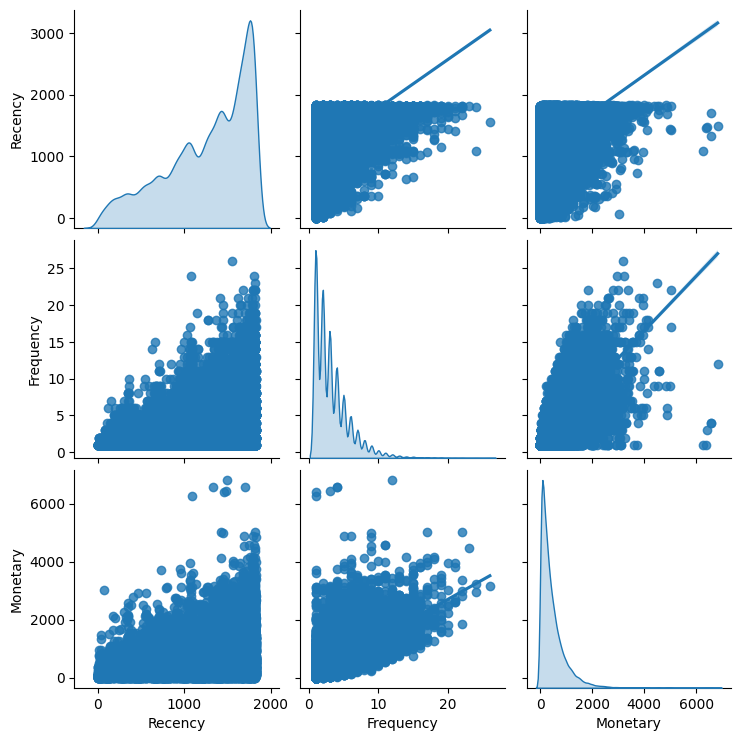

In [120]:
rfm_corr = rfm_table.toPandas()

# Build a pairplot with different x and y variables
sns.pairplot(data=rfm_corr,
        vars=["Recency", "Frequency", "Monetary"],
        kind='reg',
        diag_kind = 'kde')

plt.show()

In [111]:
df2.select("Customer ID").count()

185009

In [59]:
df2.printSchema()

root
 |-- Recency: integer (nullable = true)
 |-- Product ID: long (nullable = true)
 |-- Customer ID: integer (nullable = true)
 |-- Customer Status: string (nullable = true)
 |-- Date Order was placed: date (nullable = true)
 |-- Delivery Date: date (nullable = true)
 |-- Order ID: integer (nullable = true)
 |-- Quantity Ordered: integer (nullable = true)
 |-- Total Retail Price for This Order: double (nullable = true)
 |-- Cost Price Per Unit: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Retail Price: double (nullable = true)
 |-- Profit: double (nullable = true)
 |-- Product Category: string (nullable = true)
 |-- Product Name: string (nullable = true)



In [68]:
test = (
    df2
    .withColumn("Day", day("Date Order was placed"))
    .filter((col('Year')==2017)&(col('Month')==1)&(col('Day') == 2))
)

test.show()

+-------+------------+-----------+---------------+---------------------+-------------+---------+----------------+---------------------------------+-------------------+----+-----+------------+------+--------------------+--------------------+---+
|Recency|  Product ID|Customer ID|Customer Status|Date Order was placed|Delivery Date| Order ID|Quantity Ordered|Total Retail Price for This Order|Cost Price Per Unit|Year|Month|Retail Price|Profit|    Product Category|        Product Name|Day|
+-------+------------+-----------+---------------+---------------------+-------------+---------+----------------+---------------------------------+-------------------+----+-----+------------+------+--------------------+--------------------+---+
|      1|240100400009|       1870|         Silver|           2017-01-02|   2017-01-02|123006324|               1|                             65.5|               25.6|2017|    1|        65.5|  39.9|Assorted Sports A...|Hull Ice Hockey s...|  2|
|      1|24060010008

## Frequency

In [74]:
df_freq = df2.groupBy('Customer ID').agg(count('Date Order was placed').alias('Frequency'))

df_freq.show(5,0)

+-----------+---------+
|Customer ID|Frequency|
+-----------+---------+
|148        |7        |
|53634      |8        |
|88674      |5        |
|37263      |5        |
|26755      |9        |
+-----------+---------+
only showing top 5 rows



In [75]:
df3 = df2.join(df_freq, on='Customer ID',how='inner')

df3.printSchema()

root
 |-- Customer ID: integer (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- Product ID: long (nullable = true)
 |-- Customer Status: string (nullable = true)
 |-- Date Order was placed: date (nullable = true)
 |-- Delivery Date: date (nullable = true)
 |-- Order ID: integer (nullable = true)
 |-- Quantity Ordered: integer (nullable = true)
 |-- Total Retail Price for This Order: double (nullable = true)
 |-- Cost Price Per Unit: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Retail Price: double (nullable = true)
 |-- Profit: double (nullable = true)
 |-- Product Category: string (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Frequency: long (nullable = false)



In [76]:
df3.show(5)

+-----------+-------+------------+---------------+---------------------+-------------+---------+----------------+---------------------------------+-------------------+----+-----+------------+------+-----------------+--------------------+---------+
|Customer ID|Recency|  Product ID|Customer Status|Date Order was placed|Delivery Date| Order ID|Quantity Ordered|Total Retail Price for This Order|Cost Price Per Unit|Year|Month|Retail Price|Profit| Product Category|        Product Name|Frequency|
+-----------+-------+------------+---------------+---------------------+-------------+---------+----------------+---------------------------------+-------------------+----+-----+------------+------+-----------------+--------------------+---------+
|        291|    148|240500100064|       Platinum|           2017-05-29|   2017-06-13|123015210|               1|                             55.7|               24.2|2017|    5|        55.7|  31.5|Running - Jogging|Ypsilon Pants Inf...|        7|
|       

## Monetary Value

In [78]:
m_val = df3.groupBy('Customer ID').agg(round(sum('Total Retail Price for This Order'),2).alias('Monetary Value'))

m_val.show(5)

+-----------+--------------+
|Customer ID|Monetary Value|
+-----------+--------------+
|        148|        1090.9|
|      53634|         741.4|
|      88674|         264.8|
|      37263|        1578.3|
|      26755|        2102.1|
+-----------+--------------+
only showing top 5 rows



In [90]:
finaldf = m_val.join(df3,on='Customer ID',how='inner')

In [92]:
finaldf = finaldf.select(['Recency','Frequency','Monetary Value','Customer ID']).distinct()

finaldf.toPandas().tail(10)

,Recency,Frequency,Monetary Value,Customer ID
184595,1648,9,883.5,94252
184596,1619,9,883.5,94252
184597,1586,9,883.5,94252
184598,1105,9,883.5,94252
184599,1126,9,883.5,94252
184600,1229,9,883.5,94252
184601,343,9,883.5,94252
184602,169,9,883.5,94252
184603,554,2,813.2,94253
184604,602,2,813.2,94253


In [103]:
new = spark.read.csv('Dataset/retail_orders_new.csv',
                    header=True,
                    escape="\"")

new.printSchema()

root
 |-- SKU: string (nullable = true)
 |-- OrderNum: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Sale Price: string (nullable = true)
 |-- SKU Description: string (nullable = true)
 |-- Created On: string (nullable = true)
 |-- Category: string (nullable = true)



In [104]:
new = new.withColumn("OrderDate", to_date(unix_timestamp("Created On", "yyyy-MM-dd").cast("timestamp")))

In [107]:
(new
 .where(col("OrderDate") == new.agg(min("OrderDate")).first()[0])
 .select(["OrderDate"])
 .show())

+----------+
| OrderDate|
+----------+
|2015-06-02|
|2015-06-02|
|2015-06-02|
|2015-06-02|
|2015-06-02|
|2015-06-02|
|2015-06-02|
|2015-06-02|
|2015-06-02|
|2015-06-02|
|2015-06-02|
|2015-06-02|
|2015-06-02|
|2015-06-02|
|2015-06-02|
|2015-06-02|
|2015-06-02|
|2015-06-02|
|2015-06-02|
|2015-06-02|
+----------+
only showing top 20 rows

